In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Reading / Writing

In [2]:
gdf = gpd.read_file('sig.shp', encoding='CP949')
df = pd.read_csv('_essential15.csv', sep=',', header=0, encoding='CP949')
df.head()

,code,geo,pop,emp_res,emp
0,11110,종로구,154986,72265,295339
1,11140,중구,125733,59861,367256
2,11170,용산구,233342,106678,158693
3,11200,성동구,297003,144719,162332
4,11215,광진구,360369,181481,143502


In [13]:
# WHEN YOU NEED TO WORK ON SHP IN EXCEL
shp_out = gdf[['SIG_CD', 'SIG_KOR_NM']]
shp_out['area'] = gdf.area
shp_out.to_csv('sig_geo.csv', encoding='CP949', index=False)

In [3]:
gdf_sorted = gdf.sort_values(by='SIG_CD')

# rhovec = df.emp/gdf_sorted.area
# index = gdf_sorted.SIG_CD.to_numpy().astype(int)
# rhovec.index = index
gdf_sorted['rho'] = 1e+6 * df.emp/gdf_sorted.area
gdf_sorted['rho_log'] = 6 + np.log10(df.emp/gdf_sorted.area)
gdf_sorted.head()

,SIG_CD,SIG_KOR_NM,geometry,rho,rho_log
159,11110,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1...",4014.206502,3.603600
154,11140,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1...",5297.623945,3.724081
144,11170,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1...",1243.471938,3.094636
142,11200,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1...",3680.126854,3.565863
153,11215,광진구,"POLYGON ((964825.082 1952633.250, 964875.590 1...",3432.276632,3.535582


# Glimpse

In [4]:
gdf_sorted.sort_values(by='rho', ascending=False).head(5)

,SIG_CD,SIG_KOR_NM,geometry,rho,rho_log
18,41115,수원시 팔달구,"POLYGON ((958858.331 1921730.191, 958913.122 1...",27994.271562,4.447069
22,41111,수원시 장안구,"POLYGON ((957466.968 1928109.204, 957495.822 1...",21912.946925,4.340701
114,27110,중구,"POLYGON ((1099266.034 1764845.475, 1099328.023...",14531.377930,4.162307
23,41173,안양시 동안구,"POLYGON ((952571.411 1938090.489, 952708.664 1...",13688.362087,4.136351
36,41199,부천시 오정구,"POLYGON ((935200.041 1950743.880, 935205.583 1...",10752.672103,4.031516


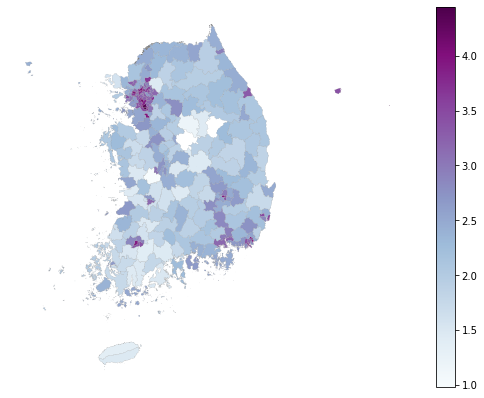

In [5]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_axis_off()

gdf_sorted.plot(column='rho_log', ax=ax, cmap='BuPu', edgecolor='gray', linewidth=0.1, legend=True)

plt.show()

# What is "City"?

In [9]:
df['rho'] = gdf_sorted['rho']
dict_city = {'수도권': [11, 28, 41],
             '부산권': [26, 31, 48],
             '대구권': [27, 47],
             '광주권': [29, 46],
             '대전권': [30, 36, 43, 44],
             '전주권': [45],
             '동해권': [42]}

dfarr_rank = []
k, P, a = [], [], 10
for city, codes in dict_city.items():
    df_city_temp = []
    for code in codes:
        temp = df[round(df['code'],-3) == 1000*code]
        df_city_temp.append(temp)
    df_city = pd.concat(df_city_temp).sort_values(by='rho', ascending=False)
    dfarr_rank.append(df_city)
    
    kcut = df_city['rho'].max() / a
    kP = df_city[df_city['rho'] >= kcut]
    k.append(len(kP))
    P.append(kP['pop'].sum())

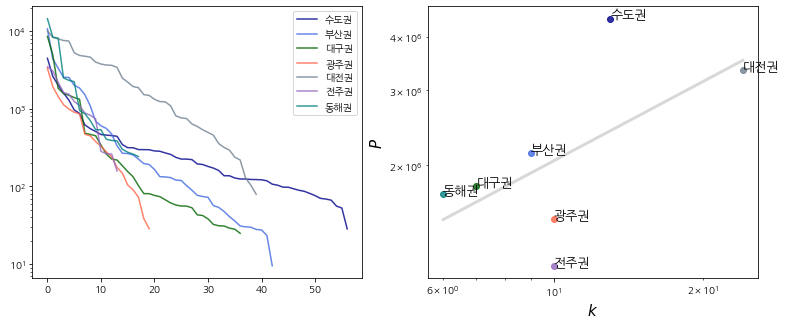

In [57]:
plt.rc('font', family='NanumGothic')
fig2, (ax_rank, ax_kp) = plt.subplots(1, 2, figsize=(13,5))

ax_kp.set_xlabel('$k$', fontsize=15)
ax_kp.set_ylabel('$P$', fontsize=15)
ax_rank.set_yscale('log')
ax_kp.set_xscale('log')
ax_kp.set_yscale('log')

AggX, AggY = [], []
palette = ['darkblue', 'royalblue', 'darkgreen', 'tomato', 'slategray', 'tab:purple', 'teal']
for i in range(len(dict_city)):
    cityname = list(dict_city.items())[i][0]
    rank = dfarr_rank[i]
    ax_rank.plot(np.arange(len(rank)), rank['rho'], color=palette[i], alpha=0.8, label=cityname)
    ax_kp.scatter(k[i], P[i], color=palette[i], alpha=0.8)
    ax_kp.text(k[i], P[i], cityname, fontsize=13)
    
    AggX.append(k[i]); AggY.append(P[i])

pfit, cov = np.polyfit(np.log(AggX), np.log(AggY), 1, cov=True)
FitX = AggX
FitY = np.exp(np.poly1d(pfit)(np.log(AggX)))

arg = np.argsort(FitX)
FitX = np.sort(FitX)
FitY = FitY[arg]
ax_kp.plot(FitX, FitY, color='gray', alpha=0.3, lw=3)

# refX = np.linspace(5,25,50)
# refY = 1e+5 * np.power(refX, 1.25)
# ax_kp.plot(refX, refY, color='gray', alpha=0.3, lw=3)

ax_rank.legend(loc='upper right')
plt.show()

In [59]:
print('pfit:', pfit)
print('stdvec:', np.sqrt(np.diag(cov)))
Rsq = np.corrcoef(np.log(AggY), np.log(FitY))[0,1]**2
print(Rsq)

pfit: [ 0.62149441 13.10178965]
stdvec: [0.3670101  0.86747969]
0.30833892414745934
